In [112]:
import numpy as np
import mpmath
from scipy import linalg
import math as m
import matplotlib.pyplot as plt
import scipy as sci
from numpy import pi
from shapely.geometry.polygon import LinearRing, Polygon
import shapely as shape
plt.rcParams["figure.figsize"] = (10,6)

In [2]:
#https://math.stackexchange.com/questions/163920/how-to-find-an-ellipse-given-five-points
#https://en.wikipedia.org/wiki/Matrix_representation_of_conic_sections


In [3]:
def Rx(theta):
    return np.array([[1,0,0],[0,np.cos(theta),-np.sin(theta)],[0,np.sin(theta),np.cos(theta)]])
def Ry(theta):
    return np.array([[np.cos(theta),0,np.sin(theta)],[0,1,0],[-np.sin(theta),0,np.cos(theta)]])
def Rz(theta):
    return np.array([
        [np.cos(theta),-np.sin(theta),0],[np.sin(theta),np.cos(theta),0],[0,0,1]])

def Ru(theta, u):
    x,y,z = u
    #print(u)
    if abs(x*x + y*y + z*z - 1) > 1e-4:
        raise(Exception("u must have a magnitude of 1"))
    return np.array([[np.cos(theta) + x*x*(1-np.cos(theta)), x*y*(1-np.cos(theta))-z*np.sin(theta), x*z*(1-np.cos(theta))+y*np.sin(theta)],
                    [y*x*(1-np.cos(theta))+z*np.sin(theta), np.cos(theta)+y*y*(1-np.cos(theta)), y*z*(1-np.cos(theta))-x*np.sin(theta)],
                    [z*x*(1-np.cos(theta))-y*np.sin(theta), z*y*(1-np.cos(theta))+x*np.sin(theta), np.cos(theta)+z*z*(1-np.cos(theta))]])

def quadratic(a,b,c):
    return (-b+(b*b-4*a*c)**(1/2))/(2*a), (-b-(b*b-4*a*c)**(1/2))/(2*a)



class Disk:
    def __init__(self, xc, yc, points):#radius could be included in another constructor
        self.pointList = [0]*len(points)
        for i in range(len(points)):
            self.pointList[i] = points[i]
        self.pointList = np.asarray(self.pointList)
        #self.pointList[:,0]+=xc
        #self.pointList[:,1]+=yc
        self.xc = xc
        self.yc = yc
        self.i = 90
        self.omega = 0
        self.abcdef = Disk.determine_abcdef(self)#quadratic coefficients
        self.matrixForm = np.array([[self.abcdef[0], self.abcdef[1]/2, self.abcdef[3]/2],
                                    [self.abcdef[1]/2, self.abcdef[2], self.abcdef[4]/2],
                                    [self.abcdef[3]/2, self.abcdef[4]/2, self.abcdef[5]]])
        #self.center=np.array([xc,yc,0])
        self.a, self.b = 0,0
        self.canonicalForm()
        self.alpha = 0#this shouldn't just be set to 0 it should be calculated
        self.xu = (1,0,0)
        self.yu = (0,1,0)
        self.zu = (0,0,1)
        self.area = self.a*self.b*pi
    
    @classmethod
    def circle(cls, xc, yc, radius):
        return cls(xc,yc, [[radius,0,0],[radius/2**(1/2),radius/2**(1/2),0],[0,radius,0],[-radius,0,0],[0,-radius,0]])
        
        
    def rotate(self,direction, amount):
        amount*=pi/180
        l = len(self.pointList)
        if direction == "x":
            for i in range(l):
                self.pointList[i] = np.dot(Ru(amount,self.xu), self.pointList[i])#-self.center)
            self.yu = np.dot(Ru(amount,self.xu),self.yu)
            self.zu = np.dot(Ru(amount,self.xu),self.zu)
            self.i+= amount*180/pi
        elif direction == "y":
            for i in range(l):
                self.pointList[i] = np.dot(Ru(amount,self.yu),self.pointList[i])
            self.xu = np.dot(Ru(amount,self.yu),self.xu)
            self.zu = np.dot(Ru(amount,self.yu),self.zu)
            self.omega+=amount*180/pi
        elif direction == "z":
            for i in range(l):
                self.pointList[i] = np.dot(Ru(amount,self.zu),self.pointList[i])
            self.xu = np.dot(Ru(amount,self.zu),self.xu)
            self.yu = np.dot(Ru(amount,self.zu),self.yu)
        else:
            raise(Exception("unknown direction, please enter x,y, or z\n"))
    def rotate2(self, amount, unitVector):
        amount*=pi/180
        p = self.pointList
        for i in range(len(p)):
            self.pointList[i] = np.dot(Ru(amount, unitVector), p[i])
        
    def updates(self):
        self.abcdef = self.determine_abcdef()
        A,B,C,D,E,F = self.abcdef
        self.matrixForm = np.array([[A, B/2, D/2],
                                   [B/2, C, E/2],
                                   [D/2, E/2, F]])
        self.detAngRot()
        self.updateCenters()
        self.canonicalForm()
    
    def updatePosition(self, vx, vy, t):
        self.xc += vx*t
        self.yc += vy*t
        for i in range(len(self.pointList)):
            self.pointList[i,0] += vx*t
            self.pointList[i,1] += vy*t
#-------------------------------------------------------
    
        
    def detAngRot(self):
        A,B,C,D,E,F = self.abcdef
        #print(A,B,C,D,E,F)
        if abs(B)<1e-5 and A < C:
            self.alpha = 0
        elif abs(B)<1e-5 and A > C:
            self.alpha = pi/2
        elif A < C:
            self.alpha= 1/2*(np.arctan(B/(A-C)))
        elif A > C:
            self.alpha= pi/2 + 1/2*(np.arctan(B/(A-C)))

    def determine_abcdef(self):
        mat = [0]*5
        for i in range(5):
            x,y,z = self.pointList[i]
            mat[i] = [x*x, x*y, y*y, x, y, 1]
        matrix = np.asarray(mat)
        coeff = [0]*6
        for i in range(6):
            coeff[i] = np.linalg.det(np.delete(matrix,i,1))
        return np.asarray(coeff)
    
    def canonicalForm(self):
        S = np.linalg.det(self.matrixForm)
        A,B,C = self.abcdef[:3]
        l1, l2 = quadratic(1, -(A+C), A*C - (B/2)**2)
        u, v = m.sqrt(abs(S/(l1**2*l2))), m.sqrt(abs(S/(l1*l2**2)))
        self.a = max(u,v)
        self.b = min(u,v)
            
    def updateCenters(self, x=0, y=0):
        A,B,C,D,E,F = self.abcdef
        self.xc += (B*E-2*C*D)/(4*A*C-B**2) + x
        self.yc += (D*B-2*A*E)/(4*A*C-B**2) + y
        
class RoundThing:
    def __init__(self, xc,yc, radius, flux=0):
        self.xc = xc
        self.yc = yc
        self.radius = radius
        self.flux = flux
        self.a = radius
        self.b = radius
        self.pointList = [[radius, 0,0], [radius/2**(1/2),radius/2**(1/2),0],[0,radius,0],[-radius,0,0],[0,-radius,0]]
        self.pointList = np.asarray(self.pointList)
    def updatePosition(self, vx, vy, t):
        self.xc += vx*t
        self.yc += vy*t
        for i in range(len(self.pointList)):
            self.pointList[i,0] += vx*t
            self.pointList[i,1] += vy*t

class Ring:
    def __init__(self, innerDisk, outerDisk, absorption=lambda l:1):
        self.i = innerDisk
        self.o = outerDisk
        self.xc = (innerDisk.xc + outerDisk.xc)/2
        self.yc = (innerDisk.yc + outerDisk.yc)/2
        self.absorptionFunction = absorption
    def rotate(self, direction, amount):
        self.i.rotate(direction, amount)
        self.o.rotate(direction, amount)
    
    def rotate2(self, amount, unitVector):
        self.i.rotate2(amount, unitVector)
        self.o.rotate2(amount, unitVector)
    def updatePosition(self, vx, vy, t):
        self.i.updatePosition(vx,vy,t)
        self.o.updatePosition(vx,vy,t)
        
    def updates(self):
        self.i.updates()
        self.o.updates()
    

    
class StarLD:
    def __init__(self, xc, yc, radius, I0, CoffList=[],layers=1,scaling='u'):
        self.xc = xc
        self.yc = yc
        self.radius = radius
        self.a = radius
        self.b = radius
        self.layers= layers
        self.I0 = I0
        self.pointList = StarLD.pConstruct(xc,yc,radius)
        self.aList = CoffList
        self.dList = [0]*layers
        self.dList[-1] = Disk.circle(xc,yc,radius)
        dr = radius/layers
        for i in range(layers-1):
            self.dList[i] = Disk.circle(xc,yc,dr*(i+1))
    
    def pConstruct(xc,yc,radius):
        return np.array([[radius+xc, yc,0], [radius/2**(1/2)+xc,radius/2**(1/2)+yc,0],
                          [xc,radius+yc,0],[-radius+xc,yc,0],[xc,-radius+yc,0]])
    def updatePosition(self, vx, vy, t):
        self.xc += vx*t
        self.yc += vy*t
        for i in range(len(self.pointList)):
            self.pointList[i,0] += vx*t
            self.pointList[i,1] += vy*t
    def LD(self, theta, omega):
        rSum = 1
        aList = self.aList
        l = len(aList)
        for i in range(1,l):
            rSum+=aList[i]*(1-(1-(np.sin(theta)/np.sin(omega))**2)**(1/2))**i
        return rSum

In [28]:
def calculateAngles(p0,pointList):
    x,y = p0
    l = len(pointList)
    returnList = [0]*l
    for i in range(l):
        returnList[i] = np.arctan2(pointList[i][1]-y,pointList[i][0]-x)
    return returnList

def area(o1, o2):
    ellipses = [(o1.xc,o1.yc,o1.a,o1.b, o1.alpha),#np.arctan2(o1.pointList[0,1]-o1.yc,o1.pointList[0,0]-o1.xc)),
               (o2.xc,o2.yc,o2.a,o2.b, o2.alpha)]#np.arctan2(o2.pointList[0,1]-o2.yc,o2.pointList[0,0]-o2.xc))]
    a,b = ellipse_polyline(ellipses)

    e1 = Polygon(a)
    e2 = Polygon(b)
    
    a1 = e1.intersection(e2).area
    return a1
    #if a1:
    #    return a1
    #return e2.intersection(e1).area

def ellipse_polyline(ellipses, n=100):
    t = np.linspace(0, 2*pi, n)
    st = np.sin(t)
    ct = np.cos(t)
    result = []
    for x0, y0, a, b, angle in ellipses:
        sa = np.sin(angle)
        ca = np.cos(angle)
        p = np.empty((n, 2))
        p[:, 0] = x0 + a * ca * ct - b * sa * st
        p[:, 1] = y0 + a * sa * ct + b * ca * st
        result.append(p)
    return result    


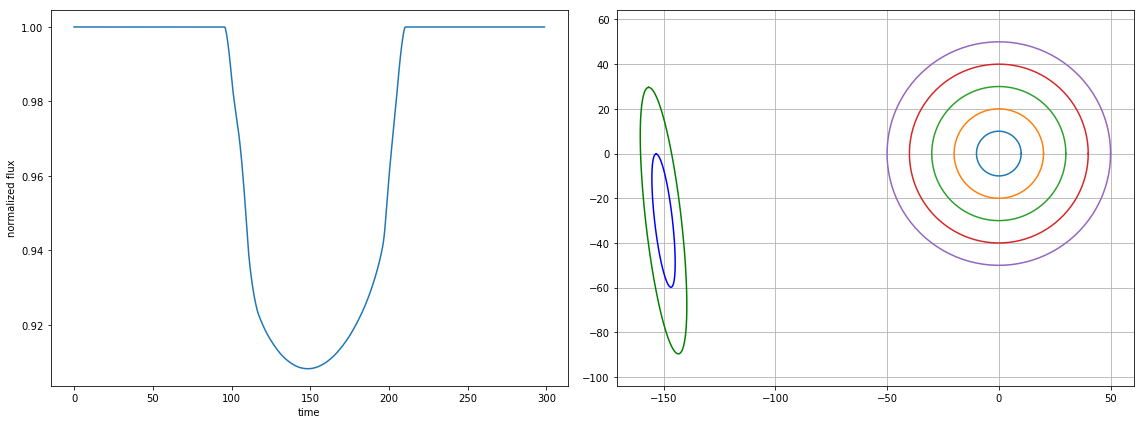

In [36]:
#multi rings
innerNumber = 20
outerNumber = 40
xOffSet = -200
yOffSet = -30
xRot = 80
yRot = 40
InnerDisk = Disk.circle(xOffSet,yOffSet, innerNumber)
OuterDisk = Disk.circle(xOffSet,yOffSet, outerNumber)



Star = StarLD(0,0,50,1, CoffList=[-0.47,-0.23], layers=5)#RoundThing(0,0, 10, 1)
R1 = Ring(InnerDisk, OuterDisk)
R2 = Ring(Disk.circle(xOffSet,yOffSet, innerNumber+outerNumber+5), Disk.circle(xOffSet,yOffSet, 2*outerNumber+40))
dist = 10000

RList = [R1,R2]
for R in RList:
    R.rotate("x", xRot)
    R.rotate("y", yRot)
    R.updates()#we can't see z since we're projecting on the sky


start = 1
end = 300
points = 1000

dt = (end-start)/points

vx = lambda t : 1#0.1
vy = lambda t: 0

#need a local distance so that we can scale the amount of coverage
output = [0]*points

ringArray = [[0]*points for i in range(2*len(RList))]


w = Star.radius/dist


h = Star.layers

for j in range(points):
    for apples in range(len(RList)):
        R = RList[apples]
        output[j]+= Star.I0*Star.LD(w/(2*h),w)*(-area(Star.dList[0],R.o)+area(Star.dList[0],R.i))
        for i1 in range(1,h):
            output[j]+= Star.I0*Star.LD((i1+1)*w/(2*h),w)*\
            (-(area(Star.dList[i1],R.o)-area(Star.dList[i1],R.i)-area(Star.dList[i1-1],R.o)+area(Star.dList[i1-1],R.i)))

        ringArray[2*apples][j] = (R.i.xc, R.i.yc, R.i.a, R.i.b, R.i.alpha)
        ringArray[2*apples+1][j]= (R.o.xc, R.o.yc, R.o.a, R.o.b, R.o.alpha)
        #ringListi[j] = (R.i.xc, R.i.yc, R.i.a, R.i.b, R.i.alpha)
        #ringListo[j] = (R.o.xc, R.o.yc, R.o.a, R.o.b, R.o.alpha)

        R.updatePosition(vx(j*dt),vy(j*dt),dt)
    output[j]/=pi*Star.radius**2
    output[j]+=1
    Planet.updatePosition(vx(j*dt),vy(j*dt),dt)

fig = plt.figure()
sub1 = fig.add_subplot(121)
sub1.plot(np.asarray(range(points))*dt, output)
sub1.set_ylabel("normalized flux",fontsize=14)
sub1.set_xlabel("time",fontsize=14)
#fig.imsave("someName")
sub2 = fig.add_subplot(122)
sub2.plot()

ellipses = [ringArray[i][0] for i in range(len(ringArray))]
#print(ellipses)
graphingList = ellipse_polyline(ellipses)
i = 0
while i < len(graphingList):
    sub2.plot(graphingList[i][:,0], graphingList[i][:,1],'b')
    sub2.plot(graphingList[i+1][:,0], graphingList[i+1][:,1],'g',label="Ring")
    i+=2

#self.dList[i] = Disk.circle(xc,yc,dr*(i+1))
# starList = [0]*Star.layers
# for i in range(Star.layers):
#     disk = Star.dList[i]
#     starList[i] = (Star.xc, Star.yc, disk.a, disk.b, 0)

s1 = ellipse_polyline([(Star.xc, Star.yc, Star.a, Star.b, 0)])[0]
p1 = ellipse_polyline([(xOffSet,yOffSet, Planet.a, Planet.b, 0)])[0]
# s1 = ellipse_polyline(starList)
# for i in s1:
#     sub2.plot(i[:,0],i[:,1],label="Star")
sub2.plot(s1[:,0],s1[:,1],'m',label='Star')
sub2.plot(p1[:,0],p1[:,1],'r',label='Planet')
sub2.set_title("Initial Geometry for $R_x$ = %.1f$^o$,$R_y$ = %.1f$^o$"%(xRot,yRot), fontsize=16)
plt.axis('equal')
sub1.set_title("LC for $R_x$ = %.1f$^o$,$R_y$ = %.1f$^o$"%(xRot,yRot),fontsize=16)
plt.grid()
plt.tight_layout()
#plt.savefig("/home/tyler/Desktop/Planets/ring28040.png", dpi=400)
plt.legend()
plt.show()

#vary Xamount, vary Yamount, vary Ring radius, vary ring width, vary planet inclination